jupyter:
  jupytext:
    text_representation:
      extension: .py
      format_name: light
      format_version: '1.5'
      jupytext_version: 1.13.6
  kernelspec:
    display_name: Python 3 (ipykernel)
    language: python
    name: python3

# CA housing pandas profiling visualization

## Setup libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

In [3]:
import seaborn as sns

In [4]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

In [5]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [6]:
from lightgbm import LGBMRegressor

In [7]:
import matplotlib.pyplot as plt

In [8]:
from pandas_profiling import ProfileReport

In [9]:
%matplotlib inline

## Get data

In [10]:
california_housing = fetch_california_housing(as_frame=True)

## Useful functions

In [11]:
def print_model_performance(test_data, pred_data):
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    print("R2 {:.3f}, mse {:.3f}".format(r2, mse))

## Data summary

In [12]:
housing_raw = california_housing.frame

In [13]:
housing_raw.shape

(20640, 9)

List missing values

In [14]:
housing_raw.isna().sum()

MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

## Get training and test data

In [15]:
housing_df, housing_unseen = train_test_split(
    housing_raw, test_size=0.2, random_state=42, shuffle=True
)

In [16]:
y_train = housing_df.MedHouseVal
X_train = housing_df.drop(columns=['MedHouseVal'])

## Gradient boosting regression

In [17]:
gbm = LGBMRegressor()
gbm.fit(X_train, y_train)

LGBMRegressor()

In [18]:
reg = make_pipeline(
    StandardScaler(), SGDRegressor(max_iter=1000, tol=1e-3))
reg.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor', SGDRegressor())])

In [19]:
y_test = housing_unseen.MedHouseVal
X_test = housing_unseen.drop(columns='MedHouseVal')

In [20]:
y_pred = gbm.predict(X_test)
print_model_performance(y_test, y_pred)

R2 0.836, mse 0.215


In [21]:
y_pred = reg.predict(X_test)
print_model_performance(y_test, y_pred)

R2 0.413, mse 0.769


## Feature importances

In [22]:
y_data = housing_raw.MedHouseVal
X_data = housing_raw.drop(columns=['MedHouseVal'])

In [23]:
p_importance = permutation_importance(
    gbm, X_data, y_data, n_repeats=10, random_state=0)

In [24]:
p_importance_df = pd.DataFrame({
    'feature': X_data.columns,
    'importance': p_importance.importances_mean
}).sort_values(by='importance', ascending=False)

<AxesSubplot:xlabel='importance', ylabel='feature'>

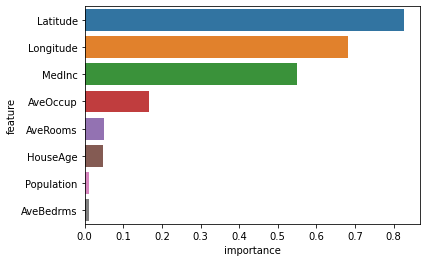

In [25]:
sns.barplot(x='importance', y='feature', data=p_importance_df)

<AxesSubplot:>

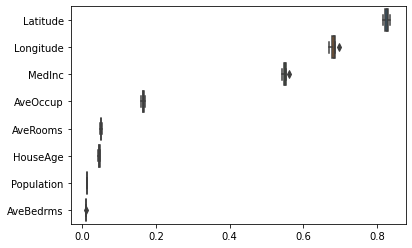

In [26]:
p_importance_df = pd.DataFrame(
    p_importance.importances.T, columns=X_data.columns)
importance_order = p_importance_df.mean().sort_values(
    ascending=False).index.tolist()
sns.boxplot(data=p_importance_df, orient='h', order=importance_order)

## Pandas profiling

In [27]:
profile = ProfileReport(housing_raw, title="CA Housing")

profile.to_widgets()

## Skewed variables

In [28]:
cols = ['AveRooms', 'AveBedrms', 'AveOccup']
housing_raw[cols].describe()

,AveRooms,AveBedrms,AveOccup
count,20640.000000,20640.000000,20640.000000
mean,5.429000,1.096675,3.070655
std,2.474173,0.473911,10.386050
min,0.846154,0.333333,0.692308
25%,4.440716,1.006079,2.429741
50%,5.229129,1.048780,2.818116
75%,6.052381,1.099526,3.282261
max,141.909091,34.066667,1243.333333


In [29]:
housing_raw[cols].quantile([0.5, 0.9, 0.99, 0.999])

,AveRooms,AveBedrms,AveOccup
0.500,5.229129,1.048780,2.818116
0.900,6.961188,1.172727,3.885273
0.990,10.357033,2.127541,5.394812
0.999,34.199698,6.617232,13.630443


In [30]:
housing_data = housing_raw[
    (housing_raw.AveRooms <= 10) &
    (housing_raw.AveBedrms < 2) &
    (housing_raw.AveOccup < 5)].reset_index(drop=True)

In [31]:
housing_raw.shape, housing_data.shape

((20640, 9), (20022, 9))

In [32]:
profile = ProfileReport(housing_data, title="CA Housing")
# profile.to_widgets()

## SGD Regressor

## Predict using cleaned data

In [33]:
housing_train, housing_test = train_test_split(
    housing_data, test_size=0.2, random_state=42, shuffle=True
)

In [34]:
y_train = housing_train.MedHouseVal
X_train = housing_train.drop(columns=['MedHouseVal'])

In [35]:
gbm = LGBMRegressor()
gbm.fit(X_train, y_train)

LGBMRegressor()

In [36]:
reg = make_pipeline(
    StandardScaler(), SGDRegressor(max_iter=1000, tol=1e-3))
reg.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor', SGDRegressor())])

In [37]:
y_test = housing_test.MedHouseVal
X_test = housing_test.drop(columns=['MedHouseVal'])

In [38]:
y_pred = gbm.predict(X_test)
print_model_performance(y_test, y_pred)

R2 0.831, mse 0.225


In [39]:
y_pred = reg.predict(X_test)
print_model_performance(y_test, y_pred)

R2 0.648, mse 0.468
